In [4]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-fjh2g1s0
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-fjh2g1s0
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ac6ee36acee1e47446cd66f72f540c87f1f1fbe4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.1-py3-none-any.whl size=13927 sha256=6682e8e65b59d69782cb2d9bca4e79999312794ec3bc32a0f94bdc00b2948213
  Stored in directory: /tmp/pip-ephem-wheel-cache-2darawn0/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


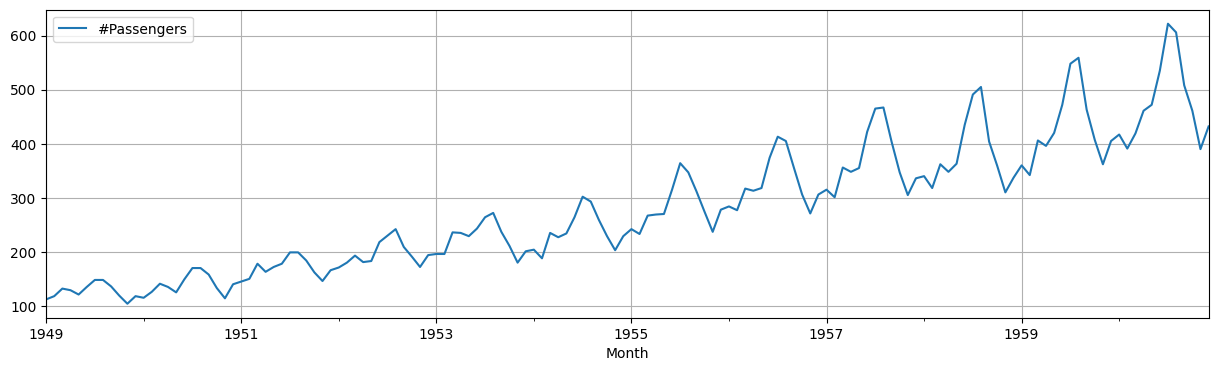

In [6]:
df ["Month"] = pd.to_datetime(df ["Month"])
df = df.set_index("Month").sort_index()
df.plot(figsize=(15, 4), grid=True);

In [7]:
df_train = df.loc[df.index < "1960-01-01"].copy()
df_test = df.loc[df.index >= "1960-01-01"].copy()
print("datos de entrenamiento:", len(df_train), "datos de evaluación:", len(df_test))

datos de entrenamiento: 132 datos de evaluación: 12


In [11]:
pipeline = ChronosPipeline.from_pretrained(
"amazon/chronos-t5-small",
device_map="cpu", # use "cpu" for CPU inference and "mps" for Apple
torch_dtype=torch.bfloat16,
)

forecast = pipeline.predict(
context=torch.tensor(df_train["#Passengers"]),
prediction_length=12,
num_samples=20,
)

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [12]:
forecast.shape

torch.Size([1, 20, 12])

In [13]:
forecast

tensor([[[400.2817, 386.8107, 429.1482, 409.9039, 436.8459, 508.0499, 602.3470,
          611.9691, 523.4453, 461.8635, 423.3749, 463.7879],
         [409.9039, 390.6595, 436.8459, 419.5260, 434.9215, 523.4453, 588.8760,
          608.1203, 498.4277, 440.6948, 390.6595, 436.8459],
         [402.2061, 377.1886, 450.3169, 450.3169, 459.9391, 529.2186, 594.6493,
          602.3470, 525.3698, 458.0146, 413.7527, 448.3925],
         [421.4505, 406.0550, 463.7879, 465.7124, 490.7300, 565.7828, 623.5158,
          642.7601, 552.3118, 479.1834, 434.9215, 471.4857],
         [417.6016, 404.1306, 459.9391, 450.3169, 465.7124, 534.9919, 602.3470,
          604.2714, 500.3521, 442.6192, 392.5840, 444.5436],
         [407.9795, 384.8863, 429.1482, 413.7527, 432.9970, 494.5789, 575.4050,
          577.3294, 479.1834, 429.1482, 382.9619, 421.4505],
         [419.5260, 407.9795, 467.6368, 458.0146, 481.1078, 561.9340, 615.8180,
          640.8356, 542.6896, 471.4857, 407.9795, 442.6192],
         [411

In [15]:
forecast_values = [float((forecast[0, :, x].mean())) for x in range(forecast.shape[2]) ]
forecast_values

[412.2132263183594,
 394.7970886230469,
 450.12451171875,
 437.80810546875,
 458.880615234375,
 529.2186279296875,
 603.3092041015625,
 614.6633911132812,
 519.5003051757812,
 452.43377685546875,
 403.93817138671875,
 449.8358459472656]

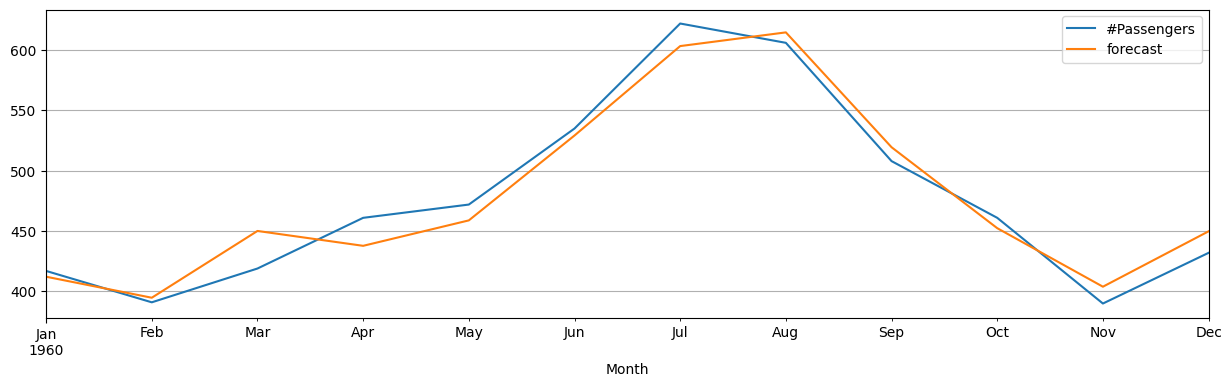

In [16]:
df_test["forecast"] = forecast_values
df_test.plot(figsize=(15, 4), grid=True);

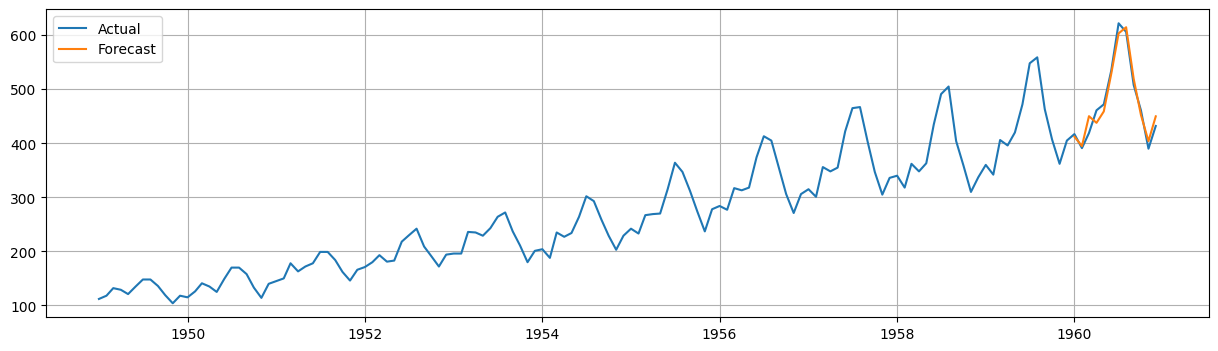

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(df ["#Passengers"], label='Actual')
plt.plot(df_test ["forecast"], label='Forecast')
plt.legend()
plt.grid()
plt.show()

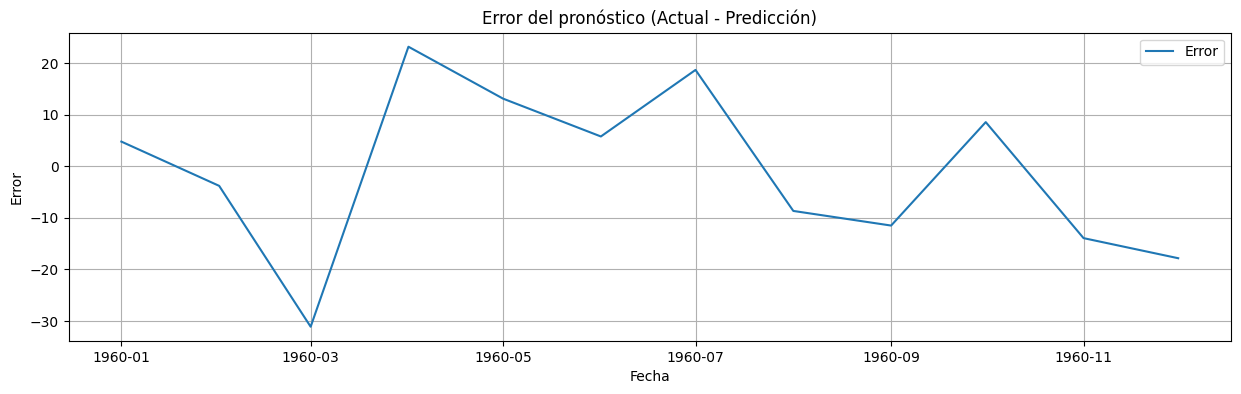

In [18]:
#Grafico de error |actual-forescast| en el ultimo año

# Calcula el error
df_test["error"] = df_test["#Passengers"] - df_test["forecast"]

# Grafica el error
plt.figure(figsize=(15, 4))
plt.plot(df_test["error"], label="Error")
plt.title("Error del pronóstico (Actual - Predicción)")
plt.xlabel("Fecha")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

In [19]:
# Calcula el error promedio
average_error = df_test["error"].mean()

# Imprime el error promedio
print(f"El error promedio del último año es: {average_error}")

El error promedio del último año es: -1.0602391560872395


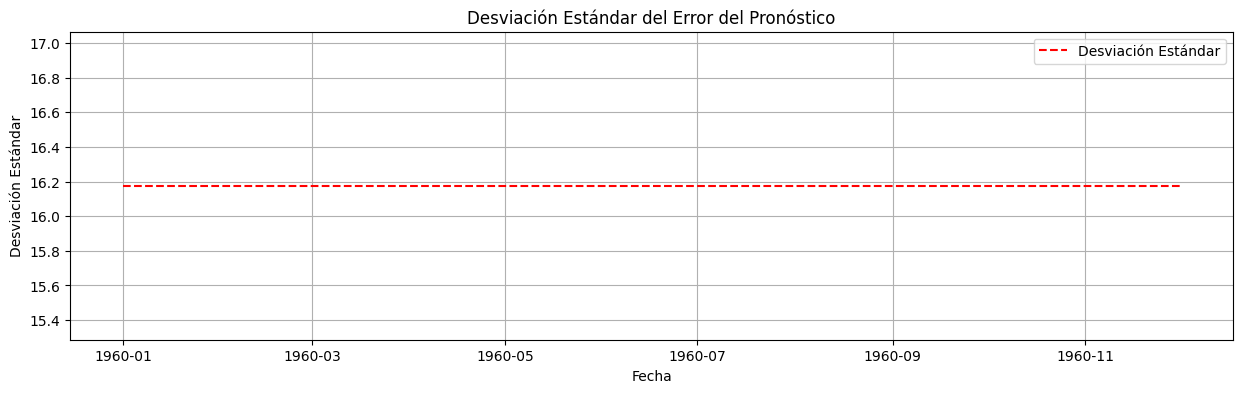

In [21]:
# Calcula la desviación estándar del error
std_error = df_test["error"].std()

# Grafica la desviación estándar
plt.figure(figsize=(15, 4))
plt.plot(df_test.index, [std_error] * len(df_test), label="Desviación Estándar", color="red", linestyle="--")
plt.title("Desviación Estándar del Error del Pronóstico")
plt.xlabel("Fecha")
plt.ylabel("Desviación Estándar")
plt.legend()
plt.grid()
plt.show()